In [2]:
from __future__ import division
from os.path import join, basename, exists
from os import makedirs
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline

from nilearn import input_data, datasets, plotting, regions
from nilearn.image import concat_imgs
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from scipy.stats import pearsonr

import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio
import nipype.interfaces.utility as util
from nipype.interfaces.fsl import InvWarp

import bct
import json
import numpy as np
import pandas as pd

ModuleNotFoundError: No module named 'nipype'

In [2]:
!which python

/Users/Katie/anaconda3/bin/python


In [11]:
def preproc(data_dir, sink_dir, subject, run, highpass, masks, mask_names):
    from nipype.interfaces.fsl import MCFLIRT, FLIRT, FNIRT, ExtractROI, ApplyWarp, MotionOutliers
    from nilearn.plotting import plot_roi
    from nilearn import input_data
    
    #WRITE A DARA GRABBER
    
    standard = '/home/applications/fsl/5.0.8/data/standard/MNI152_T1_2mm_brain.nii.gz'
    qa1 = join(sink_dir, 'qa', '{0}_mni_flirt_{1}.png'.format(subject, run))
    qa2 = join(sink_dir, 'qa', '{0}_mni_fnirt_{1}.png'.format(subject, run))
    confound_file = join(data_dir, subject, 'session-1', 'retr', 'mni', 'confounds-{0}.csv'.format(run))
    
    #run motion correction
    mcflirt = MCFLIRT(ref_vol=144, save_plots=True, output_type='NIFTI_GZ')
    mcflirt.inputs.in_file = join(data_dir, subject, 'session-1', 'retr', 'retr-{0}'.format(run), 'retr.nii.gz')
    mcflirt.inputs.out_file = join(data_dir, subject,'session-1', 'retr', 'mni', 'mcf-func-{0}.nii.gz'.format(run))
    flirty = mcflirt.run()
    
    #motion outliers
    mout = MotionOutliers(no_motion_correction=True, metric='fd')
    mout.inputs.in_file = flirty.outputs.out_file
    moutliers = mout.run()
    
    #concatenate motion parameters and motion outliers to form confounds file
    motion = np.genfromtxt(flirty.outputs.par_file)
    outliers = np.genfromtxt(moutliers.outputs.out_file)
    conf = np.hstack((motion, outliers))
    np.savetxt(confound_file, conf, delimiter=',')
    
    #extract an example volume for normalization
    ex_fun = ExtractROI(t_min=144, t_size=1)
    ex_fun.inputs.in_file = flirty.outputs.out_file
    ex_fun.outputs.roi_file = join(data_dir, subject,'session-1', 'retr', 'mni', 'example-func-{0}.nii.gz'.format(run))
    fun = ex_fun.run()
    
    #two-step normalization with flirt and fnirt, outputting qa pix
    flit = FLIRT(cost_func="corratio", dof=7)
    flit.inputs.ref_file = fun.outputs.roi_file
    flit.inputs.in_file = standard
    flit.inputs.out_file = join(data_dir, subject, 'session-1', 'retr', 'mni', 'mni-flirt-func-{0}.nii.gz'.format(run))
    flit.inputs.out_matrix_file = join(data_dir, subject, 'session-1', 'retr', 'mni', 'mni-to-func-{0}.mat'.format(run))
    reg1 = flit.run()
    #plot flirted MNI overlaid on example_func
    plot_roi(reg1.outputs.out_file, bg_img=fun.outputs.roi_file, colorbar=True, draw_cross=False, output_file=qa1)
    
    perf = FNIRT(output_type='NIFTI_GZ')
    perf.inputs.warped_file = join(data_dir, subject, 'session-1', 'retr', 'mni', 'mni-fnirt-func-{0}.nii.gz'.format(run))
    perf.inputs.affine_file = reg1.outputs.out_matrix_file
    perf.inputs.in_file = standard
    perf.inputs.ref_file = fun.outputs.roi_file
    reg2 = perf.run()
    #plot fnirted MNI overlaid on example func
    plot_roi(reg2.outputs.warped_file, bg_img=fun.outputs.roi_file, colorbar=True, draw_cross=False, output_file=qa2)
    
    xfmd_ntwks = []
    for i in np.arange(0, len(masks)):
        warp = ApplyWarp(interp="nn", abswarp=True)
        warp.inputs.in_file = masks[i]
        warp.inputs.ref_file = fun.outputs.roi_file
        warp.inputs.field_file = reg2.outputs.field_file
        net_warp = warp.run()
        xfmd_ntwks.append(net_warp.outputs.out_file)
        
        qa_file = join(sink_dir, 'qa', '{0}_ntwk_qa_{1}-{2}.png'.format(subject, mask_names[i], run))

        plotting.plot_roi(net_warp.outputs.out_file, bg_img=fun.outputs.roi_file, 
                          colorbar=True, vmin=0, vmax=18, draw_cross=False, output_file=qa_file)
    
    ntwk_masker = input_data.NiftiLabelsMasker(xfmd_ntwks[0], standardize=True, high_pass=highpass, t_r=2.0)
    hippo_masker = input_data.NiftiLabelsMasker(xfmd_ntwks[1], standardize=True, high_pass=highpass, t_r=2.0)
    
    return flirty.outputs.out_file, confound_file, ntwk_masker, hippo_masker

In [28]:
from nipype.interfaces.fsl import MCFLIRT, FLIRT, FNIRT, ExtractROI, ApplyWarp, MotionOutliers
standard = '/Users/Katie/Dropbox/Data/templates/Colin27_T1_seg_MNI-152.nii.gz'
perf = FNIRT(output_type='NIFTI_GZ')
perf.inputs.warped_file = '/Users/Katie/Dropbox/Data/hypothalamus/HIP007/H-tract-2016/struc2diff.nii.gz'
perf.inputs.affine_file = '/Users/Katie/Dropbox/Data/hypothalamus/HIP007/H-tract-2016/struc2diff.mat'
perf.inputs.in_file = standard
perf.inputs.ref_file = '/Users/Katie/Dropbox/Data/hypothalamus/HIP007/H-tract-2016/nodif.nii.gz'
#perf.inputs.fieldcoeff_file = join(data_dir, '101', 'session-1', 'retr', 'mni', 'mni-fnirt-func-1-coeff.nii.gz')
print perf.cmdline

warp = ApplyWarp(interp='nn')
warp.inputs.in_file = masks[0]
warp.inputs.ref_file = '/Users/Katie/Dropbox/Data/hypothalamus/HIP007/H-tract-2016/nodif.nii.gz'
warp.inputs.field_file = '/Users/Katie/Dropbox/Data/habenula/output/HIP002/reg/HIP002_anat2std_warp.nii.gz'
print warp.cmdline

fnirt --aff=/Users/Katie/Dropbox/Data/hypothalamus/HIP007/H-tract-2016/struc2diff.mat --in=/Users/Katie/Dropbox/Data/templates/Colin27_T1_seg_MNI-152.nii.gz --logout=/Users/Katie/Dropbox/Projects/physics-retrieval/scripts/idconn-retrieval/Colin27_T1_seg_MNI-152_log.txt --ref=/Users/Katie/Dropbox/Data/hypothalamus/HIP007/H-tract-2016/nodif.nii.gz --iout=/Users/Katie/Dropbox/Data/hypothalamus/HIP007/H-tract-2016/struc2diff.nii.gz
applywarp --in=/Users/Katie/Dropbox/Projects/physics-retrieval/18-networks-5.14.nii.gz --ref=/Users/Katie/Dropbox/Data/hypothalamus/HIP007/H-tract-2016/nodif.nii.gz --out=/Users/Katie/Dropbox/Projects/physics-retrieval/scripts/idconn-retrieval/18-networks-5.14_warp.nii.gz --warp=/Users/Katie/Dropbox/Data/habenula/output/HIP002/reg/HIP002_anat2std_warp.nii.gz --interp=nn


#data grabbing function
def get_niftis(data_dir, subject_id, session, task):
    from os.path import join, exists
    t1 = join(data_dir, subject_id, 'T1W', 'anat.nii.gz')
    epi1 = join(data_dir, subject_id, 'session-{0}'.format(session-1), task, '{0}-0'.format(task), '{0}-5mm.feat'.format(task), 'filtered_func_data.nii.gz')
    epi2 = join(data_dir, subject_id, 'session-{0}'.format(session-1), task, '{0}-1'.format(task), '{0}-5mm.feat'.format(task), 'filtered_func_data.nii.gz')

    assert exists(t1), "t1 does not exist"
    assert exists(epi1), "epi does not exist"
    assert exists(epi2), "epi does not exist"
    standard = '/home/applications/fsl/5.0.8/data/standard/MNI152_T1_2mm_brain.nii.gz'
    return t1, epi1, epi2, standard

In [6]:
def mni_to_epi(data_dir, sink_dir, subject, run, masks, mask_names):
    from nipype.interfaces.fsl import InvWarp, ApplyWarp
    from nilearn import plotting
    
    example_func = join(data_dir, subject, 'session-1', 'retr', 'retr-{0}'.format(run), 'retr-5mm.feat', 'reg', 'example_func.nii.gz')
    func_to_mni = join(data_dir, subject, 'session-1', 'retr', 'retr-{0}'.format(run), 'retr-5mm.feat', 'reg', 'example_func2standard_warp.nii.gz')
    
    
    invwarp = InvWarp(output_type="NIFTI_GZ")
    invwarp.inputs.warp = func_to_mni
    invwarp.inputs.reference = example_func
    mni_warp = invwarp.run()
    
    xfmd_ntwks = []
    
    for i in np.arange(0, len(masks)):
        applywarp = ApplyWarp(interp="nn", abswarp=True)
        applywarp.inputs.in_file = masks[i]
        applywarp.inputs.ref_file = join(data_dir, subject, 'session-1', 'retr', 'retr-{0}'.format(run), 'retr-5mm.feat', 'reg', 'example_func.nii.gz')
        applywarp.inputs.field_file = mni_warp.outputs.inverse_warp
        network_warp = applywarp.run()
        xfmd_ntwks.append(network_warp.outputs.out_file) 
        
        qa_file = join(sink_dir, 'qa', '{0}_ntwk_qa_{1}.png'.format(subject, mask_names[i], run))

        plotting.plot_roi(xfmd_ntwks, bg_img=example_func, cut_coords=(-2, 5, 40), 
                          colorbar=True, vmin=0, vmax=18, draw_cross=False, 
                          output_file=qa_file)
    
    return xfmd_ntwks

In [23]:
#choose your atlas and either fetch it from Nilearn using one of the the 'datasets' functions
#laird_2011_icns = '/home/data/nbc/physics-learning/retrieval-graphtheory/18-networks-5.14.nii.gz'
laird_2011_icns = '/Users/Katie/Dropbox/Projects/physics-retrieval/18-networks-5.14.nii.gz'
#add labels for the parcellation
labels = ['limbic', 'orbitofrontal', 'basal ganglia', 'salience', 'hunger', 
          'motor learning', 'frontoparietal', 'hand', 'motor execution', 'higher order visual', 
          'lateral visual', 'medial visual', 'default mode',' cerebellum', 'left central executive', 
          'auditory', 'mouth', 'right central executive']

harvox_hippo = '/home/data/nbc/physics-learning/retrieval-graphtheory/harvox-hippo-prob50-2mm.nii.gz'
masks = [laird_2011_icns, harvox_hippo]
mask_names = ['18_icn, hippo']

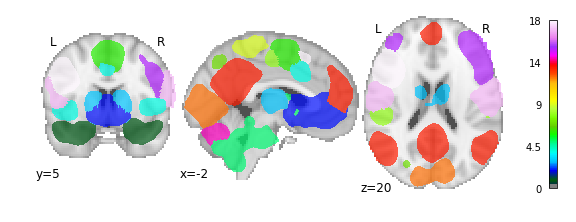

In [8]:
plotting.plot_roi(laird_2011_icns, cut_coords=(-2, 5, 20), colorbar=True, vmin=0, vmax=18, draw_cross=False)
plotting.show()
#dmn is 12
#lcen is 14
#rcen is 17

In [ ]:
plotting.plot_roi(harvox_hippo, cut_coords=(-25, -10, -6), colorbar=True, vmin=0, vmax=2, draw_cross=False)
plotting.show()

In [ ]:
plotting.plot_roi(laird_2011_icns, cut_coords=(-20, -10, 0, 10, 20, 30, 40, 50, 60, 70), 
                  display_mode='z', colorbar=True, vmin=0, vmax=20, draw_cross=False)

In [ ]:
#create your masker objects 
#(this is how to pull timeseries from niftis into arrays, based on your parcellations scheme)
#one masker to pull out one signal per network (average of voxelwise signals across the network)
#high and low-pass options are in Hertz


network_masker = input_data.NiftiLabelsMasker(laird_2011_icns, standardize=True, high_pass=)
hippo_masker = input_data.NiftiLabelsMasker(harvox_hippo, standardize=True)
#one masker to pull out one signal per region (if applicable)
#region_masker = input_data.NiftiLabelsMasker('/Users/Katie/Dropbox/Data/salience-anxiety-graph-theory/relabeled_yeo_atlas7_gt100.nii.gz', standardize=True)

In [ ]:
#only want post subjects
subjects = ['101', '102', '103', '104', '106', '107', '108', '110', '212',
            '214', '215', '216', '217', '218', '219', '320', '321', '323',
            '324', '325', '327', '328', '330', '331', '333', '334',
            '335', '336', '337', '338', '339', '340', '341', '342', '343', '344',
            '345', '346', '347', '348', '349', '350', '451', '453', '455',
            '458', '459', '460', '462', '463', '464', '465', '467',
            '468', '469', '470', '502', '503', '571', '572', '573', '574',
            '577', '578', '581', '582', '584', '585', '586', '587',
            '588', '589', '591', '592', '593', '594', '595', '596', '597',
            '598', '604', '605', '606', '607', '608', '609', '610', '612',
            '613', '614', '615', '617', '618', '619', '620', '621', '622',
            '623', '624', '625', '626', '627', '629', '630', '631', '633',
            '634']
#all subjects 102 103 101 104 106 107 108 110 212 X213 214 215 216 217 218 219 320 321 X322 323 324 325 
#327 328 X329 330 331 X332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 451 
#X452 453 455 X456 X457 458 459 460 462 463 464 465 467 468 469 470 502 503 571 572 573 574 X575 577 578 
#X579 X580 581 582 584 585 586 587 588 589 X590 591 592 593 594 595 596 597 598 604 605 606 607 608 609 
#610 X611 612 613 614 615 X616 617 618 619 620 621 622 623 624 625 626 627 X628 629 630 631 633 634
#errors in fnirt-to-mni: 213, 322, 329, 332, 452, 456, 457, 575, 579, 580, 590, 611, 616, 628
#subjects without post-IQ measure: 452, 461, 501, 575, 576, 579, 583, 611, 616, 628, 105, 109, 211, 213, 322, 326, 329, 332
#subjects = ['101', '102']

In [18]:
data_dir = '/home/data/nbc/physics-learning/data/first-level'
#data_dir = '/Users/Katie/Dropbox/Projects/physics-anxiety/'
#mni_data = '/home/data/nbc/
#mni_data = '/Users/Katie/Dropbox/Projects/physics-anxiety/data/post'
sink_dir = '/home/data/nbc/physics-learning/retrieval-graphtheory/output'
#sink_dir = '/Users/Katie/Dropbox/Projects/physics-retrieval/data/out'

runs = [0, 1]
connectivity_metric = 'correlation'
networks = [12, 14, 17]
conditions = ['phy', 'gen']
thresh_range = np.arange(0.1, 1, 0.1)

In [ ]:
#gen_timing = np.genfromtxt('/home/data/nbc/physics-learning/physics-learning/RETRconditionGeneralSess1.txt', 
#                           delimiter='\t')
gen_timing = np.genfromtxt('/home/data/nbc/physics-learning/retrieval-graphtheory/RETRconditionGeneralSess1.txt', 
                           delimiter='\t', dtype=int)

gen_timing = (gen_timing/2)-1
gen_timing = gen_timing[:,0:2]

#phy_timing = np.genfromtxt('/home/data/nbc/physics-learning/physics-learning/RETRconditionPhysicsSess1.txt', 
#                           delimiter='\t')
phy_timing = np.genfromtxt('/home/data/nbc/physics-learning/retrieval-graphtheory/RETRconditionPhysicsSess1.txt', 
                           delimiter='\t')
phy_timing = (phy_timing/2)-1
phy_timing = phy_timing[:,0:2]
timing = {}
timing['phy'] = phy_timing
timing['gen'] = gen_timing

In [ ]:
df = pd.DataFrame({'global efficiency phy': np.empty([len(subjects),], dtype=float),
                   'fc default mode-left central executive phy': np.empty([len(subjects),], dtype=float),
                   'fc default mode-right central executive phy': np.empty([len(subjects),], dtype=float),
                   'fc left central executive-right central executive phy': np.empty([len(subjects),], dtype=float),
                   'fc hippo-default mode phy': np.empty([len(subjects),], dtype=float),
                   'fc hippo-left central executive phy': np.empty([len(subjects),], dtype=float),
                   'fc hippo-right central executive phy': np.empty([len(subjects),], dtype=float),
                   'le default mode phy': np.empty([len(subjects),], dtype=float),
                   'le right central executive phy': np.empty([len(subjects),], dtype=float),
                   'le left central executive phy': np.empty([len(subjects),], dtype=float),
                   'global efficiency gen': np.empty([len(subjects),], dtype=float),
                   'fc default mode-left central executive gen': np.empty([len(subjects),], dtype=float),
                   'fc default mode-right central executive gen': np.empty([len(subjects),], dtype=float),
                   'fc left central executive-right central executive gen': np.empty([len(subjects),], dtype=float),
                   'fc hippo-default mode gen': np.empty([len(subjects),], dtype=float),
                   'fc hippo-left central executive gen': np.empty([len(subjects),], dtype=float),
                   'fc hippo-right central executive gen': np.empty([len(subjects),], dtype=float),
                   'le default mode gen': np.empty([len(subjects),], dtype=float),
                   'le right central executive gen': np.empty([len(subjects),], dtype=float),
                   'le left central executive gen': np.empty([len(subjects),], dtype=float)},
                  index=subjects)

In [ ]:
for subject in subjects:
    #print subject
    if not exists(join(sink_dir, subject)):
            makedirs(join(sink_dir, subject))
    timeseries = {}
    corrmats = {}
    hippo = {}
    for condition in conditions:
        for i in np.arange(0, len(runs)):
            example_func = 
            #xfm laird 2011 maps to subject's epi space & define masker
            epi_masks = preproc(data_dir, sink_dir, subject, i, highpass, masks, mask_names)
            network_masker = input_data.NiftiLabelsMasker(epi_masks[0], standardize=True)
            hippo_masker = input_data.NiftiLabelsMasker(epi_masks[1], standardize=True)
            plotting.plot_roi(laird_2011_icns, bg_img=example_func, cut_coords=(-2, 5, 40), 
                          colorbar=True, vmin=0, vmax=18, draw_cross=False, 
                          output_file=qa_file)
            
            
            #extract network-wise timeseries from nifti into array
            run = join(data_dir, subject, 'session-1', 'retr', 'mni', '{0}_filtered_func_data_{1}.nii.gz'.format(subject, i))
            ts = network_masker.fit_transform(run)
            hippo_ts = hippo_masker.fit_transform(run)

            #separate into different conditions
            timeseries['{0} {1}'.format(condition, i)] = np.vstack((ts[timing[condition][0,0].astype(int):(timing[condition][0,0]+timing[condition][0,1]+1).astype(int), :], ts[timing[condition][1,0].astype(int):(timing[condition][1,0]+timing[condition][1,1]+1).astype(int), :], ts[timing[condition][2,0].astype(int):(timing[condition][2,0]+timing[condition][2,1]+1).astype(int), :]))
            
            #FOR SOME REASON, THIS CAUSES THEM TO BE HSTACKED? IDK WHAT'S GOING ON
            hippo['{0} {1}'.format(condition, i)] = np.vstack((hippo_ts[timing[condition][0,0].astype(int):(timing[condition][0,0]+timing[condition][0,1]+1).astype(int)], hippo_ts[timing[condition][1,0].astype(int):(timing[condition][1,0]+timing[condition][1,1]+1).astype(int)], hippo_ts[timing[condition][2,0].astype(int):(timing[condition][2,0]+timing[condition][2,1]+1).astype(int)]))
            #print 'ts has shape {0}'.format(hippo['{0} {1}'.format(condition, i)].shape)
        #splice runs together
        timeseries[condition] = np.vstack((timeseries['{0} 0'.format(condition)], timeseries['{0} 1'.format(condition)]))
        #print 'ts {0} = {1}'.format(condition, timeseries[condition].shape)

        #compute correlation matrices per condition per run
        correlation_measure = ConnectivityMeasure(kind=connectivity_metric)
        corrmats[condition] = correlation_measure.fit_transform([timeseries[condition]])[0]
        np.savetxt(join(sink_dir, subject, '{0}-{1}-corrmat.csv'.format(subject, condition)), corrmats[condition])
    
        #populate df with network FC measures
        hippo[condition] = np.vstack((hippo['{0} 0'.format(condition)], hippo['{0} 1'.format(condition)]))
        #print 'fc default mode-left central executive {0}'.format(condition), corrmats[condition][12,14]
        df.at[subject, 'fc default mode-left central executive {0}'.format(condition)] = corrmats[condition][12,14]
        df.at[subject, 'fc default mode-right central executive {0}'.format(condition)] = corrmats[condition][12,17]
        df.at[subject, 'fc left central executive-right central executive {0}'.format(condition)] = corrmats[condition][14,17]
        
        #and since we're here, calculate graph theory measures & populate df
        ge = []
        le = {}
        loceff = {}
        loceff['default mode'] = []
        loceff['left central executive'] = []
        loceff['right central executive'] = []
        for p in thresh_range:
            corrmat_thresh = bct.threshold_proportional(corrmats[condition], p, copy=True)
            #measures of interest here
            #global efficiency
            geff = bct.efficiency_wei(corrmat_thresh)
            ge.append(geff)

            #local efficiency
            leff = bct.efficiency_wei(corrmat_thresh, local=True)
            #print leff[2]
            for network in networks:
                #print network
                loceff[labels[network]].append(leff[network])
                #loceff['{0}, {1}'.format(labels[network], condition)].append(leff[network])
            #print loceff
            le['{0}, {1}'.format(p, condition)] = loceff
        
        #print 'global efficiency is {0}'.format(ge)
        df.at[subject, 'global efficiency {0}'.format(condition)] = np.trapz(ge, dx=0.1)
        
        #populate df with hippo-FCs and local efficiencies per network
        for network in networks:
            df.at[subject, 'le {0} {1}'.format(labels[network], condition)] = np.trapz(loceff[labels[network]], dx=0.1)
            #calculate hippocampus-network correlations (FC) per network & populate df 
            network_ts = np.reshape(timeseries[condition][:,network], (84,1))
            #print(network_ts.shape)
            df.at[subject, 'fc hippo-{0} {1}'.format(labels[network], condition)] = pearsonr(hippo[condition], network_ts)[0]
df.to_csv(join(sink_dir, 'out.csv'), sep=',')

In [ ]:
print subjects

In [ ]:
local_dir = '/Users/Katie/Dropbox/Projects/physics-retrieval/data/out/'
phy = np.zeros((18, 18))
gen = np.zeros((18, 18))

for subject in subjects:
    phy += np.genfromtxt(join(local_dir, subject, '{0}-phy-corrmat.csv'.format(subject)), delimiter=' ')
    gen += np.genfromtxt(join(local_dir, subject, '{0}-gen-corrmat.csv'.format(subject)), delimiter=' ')
phy_corrmat = phy / len(subjects)
gen_corrmat = gen / len(subjects)

dif_corrmat = phy_corrmat - gen_corrmat

phy_corr_df = pd.DataFrame(phy_corrmat, index=labels, columns=labels)
gen_corr_df = pd.DataFrame(gen_corrmat, index=labels, columns=labels)
dif_corr_df = pd.DataFrame(dif_corrmat, index=labels, columns=labels)

#np.savetxt(join(local_dir, 'avg_phys_corrmat.csv'), phy_corrmat, delimiter=',')
#np.savetxt(join(local_dir, 'avg_gen_corrmat.csv'), gen_corrmat, delimiter=',')

phy_corr_df.to_csv(join(local_dir, 'avg_phys_corrmat.csv'), sep=',')
gen_corr_df.to_csv(join(local_dir, 'avg_gen_corrmat.csv'), sep=',')
dif_corr_df.to_csv(join(local_dir, 'avg_dif_corrmat.csv'), sep=',')

In [ ]:
def adj_to_list(input_filename,output_filename,delimiter):
    import pandas as pd
    import numpy as np
    import networkx as nx
    import csv
    '''https://github.com/jermainkaminski/Adjacency-Matrix-to-Edge-List/blob/master/adjacencymatrix_to_edgelist.ipynb'''
    '''Takes the adjacency matrix on file input_filename into a list of edges and saves it into output_filename'''
    A=pd.read_csv(input_filename,delimiter=delimiter,index_col=0)
    List=[('Source','Target','Weight')]
    for source in A.index.values:
        for target in A.index.values:
            List.append((target,source,A[source][target]))
    with open(output_filename, "wb") as f:
        writer = csv.writer(f)
        writer.writerows(List)
    return List

In [ ]:
phy_list = adj_to_list(join(local_dir, 'avg_phys_corrmat.csv'), join(local_dir, 'avg_phys_edges.csv'), ',')
gen_list = adj_to_list(join(local_dir, 'avg_gen_corrmat.csv'), join(local_dir, 'avg_gen_edges.csv'), ',')
dif_list = adj_to_list(join(local_dir, 'avg_dif_corrmat.csv'), join(local_dir, 'avg_dif_edges.csv'), ',')

In [ ]:
phy_list